In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
from scipy.stats import kurtosis,skew
%load_ext autoreload
%autoreload 2

In [2]:
df_data = pd.read_csv("Data/DATA.csv")
df_data = df_data.drop(columns=[col for col in df_data.keys() if "Unnamed"  in col])

In [3]:
from core.cleaning_utils import detect_cycles,temporal_plot
df_state_change, state_changes = detect_cycles(df_data)

# Basic Visualization

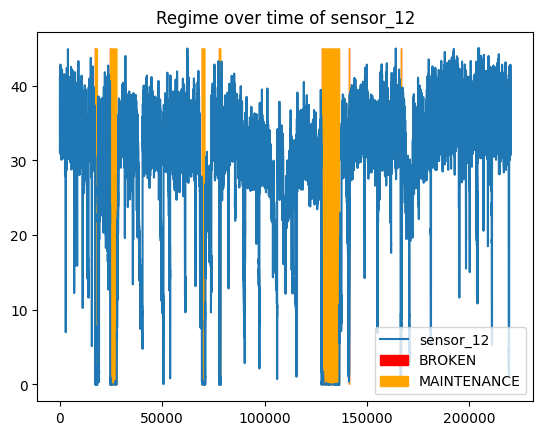

In [4]:
temporal_plot(df_data,state_changes,color_dic = {"BROKEN":"red",'MAINTENANCE':"orange"},var="sensor_12")

Text(0.5, 1.0, 'Histogram State')

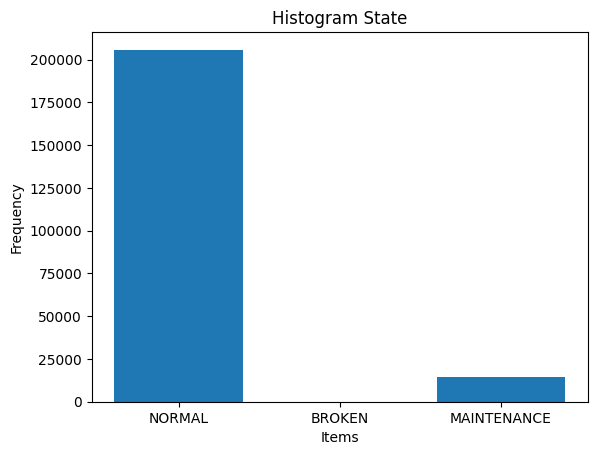

In [5]:
from collections import Counter 
states = Counter(df_data.machine_status.values)
labels = list(states.keys())
counts = list(states.values())
plt.bar(labels, counts)
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.title('Histogram State')

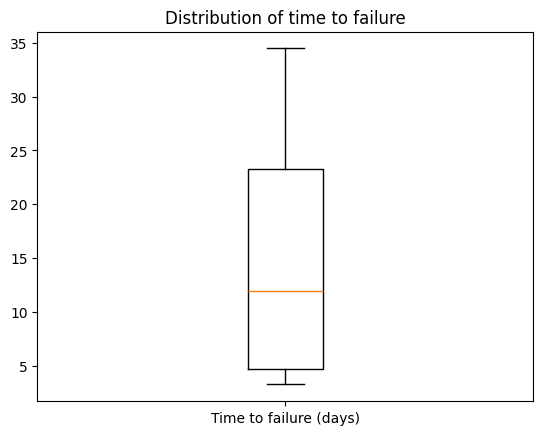

In [6]:
fig = plt.boxplot(df_state_change[df_state_change["State"]=="BROKEN"].Diff.values,"")
tt  = plt.title("Distribution of time to failure")
xt  = plt.xticks([1],["Time to failure (days)"])

# Train / Test split based on cycles

In [7]:
from core.cleaning_utils import get_cycles,cycle_train_test_split, remove_missing_data
cycles = get_cycles(df_state_change)
df_data_train, df_data_test = cycle_train_test_split(df_data, df_state_change, cycles, cycle_idx=None)

In [8]:
from core.cleaning_utils import detect_outliers
desc_stats = df_data_train[df_data_train["machine_status"].isin(["NORMAL"])].describe()
filtered_columns = detect_outliers(desc_stats)
desc_stats[filtered_columns]

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,156178.000000,155853.000000,156178.000000,156178.000000,156178.000000,156178.000000,156178.000000,156178.000000,156178.000000,156178.000000,...,156178.000000,156178.000000,156178.000000,156178.000000,156178.000000,156178.000000,156178.000000,156178.000000,79264.000000,156178.000000
mean,2.421410,47.997326,51.583706,44.413989,626.667535,74.528914,13.965362,16.254124,15.547799,15.119798,...,35.124199,44.495217,44.449639,44.735814,49.582611,45.192956,172.140391,60.395818,201.735323,196.227000
std,0.245200,2.412814,1.932297,1.664728,49.374459,9.147795,0.916712,0.641271,0.634087,0.621933,...,6.982054,8.059736,12.343479,13.453491,15.373147,10.789009,79.735981,19.702617,48.263812,37.903607
min,0.000000,0.000000,37.413190,33.289930,3.336227,0.000000,0.014468,0.028935,0.028935,0.007234,...,25.781250,28.906250,28.645830,29.224537,30.960648,30.960648,30.381940,30.092590,30.960650,30.960648
25%,2.438831,46.223960,50.781250,43.576386,628.588000,69.522715,13.382520,16.131360,15.292240,15.053530,...,32.552082,40.364580,38.194440,37.905090,41.087960,39.351852,106.770800,48.900463,180.555600,180.555600
50%,2.456539,48.003470,51.822910,44.661457,633.564800,74.641935,13.997400,16.210940,15.617770,15.082470,...,34.895830,43.489580,41.956020,41.087960,46.006940,42.534721,164.641200,54.687500,202.835600,197.338000
75%,2.500810,49.522568,52.777775,45.529511,638.078735,79.969775,14.648440,16.652199,15.733510,15.125870,...,36.718750,47.135410,46.875000,46.585650,53.240740,46.875000,227.719900,65.104160,226.273100,215.567100
max,2.549016,56.727430,55.598960,48.046880,674.768494,99.986490,15.964990,19.133390,19.538480,18.988710,...,330.468800,302.083300,1000.000000,311.342600,370.370400,220.486100,561.632000,458.622700,1000.000000,375.868000


# Remove correlated and missing Data

In [9]:
df_data_train,dropped_columns = remove_missing_data(df_data_train)

In [10]:
non_feature_columns = [col for col in df_data_train.keys() if "sensor" not in col]

In [11]:
df_data_train = df_data_train[~df_data_train.drop(columns=non_feature_columns).isna().all(axis=1)]

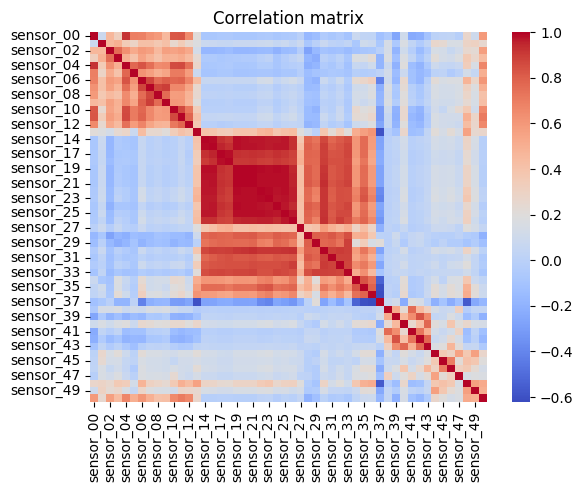

In [12]:
import seaborn as sns
corr_matrix = df_data_train.drop(columns=non_feature_columns).corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation matrix")
plt.show()

In [13]:
from core.correlation_utils import find_largest_group_of_similar_ideas,select_features_to_keep
import networkx as nx 
GROUP_MIN_SIMILARITY = 0.85

corr_matrix = df_data_train.drop(columns=non_feature_columns).dropna().corr()

g_similar_ideas = nx.from_pandas_adjacency(
    corr_matrix[corr_matrix >= GROUP_MIN_SIMILARITY].fillna(0)
)
cor_groups = find_largest_group_of_similar_ideas(g_similar_ideas, [], corr_matrix)
no_group_ideas = list(g_similar_ideas.nodes)


In [14]:
df_data_train  = select_features_to_keep(df_data_train, cor_groups)


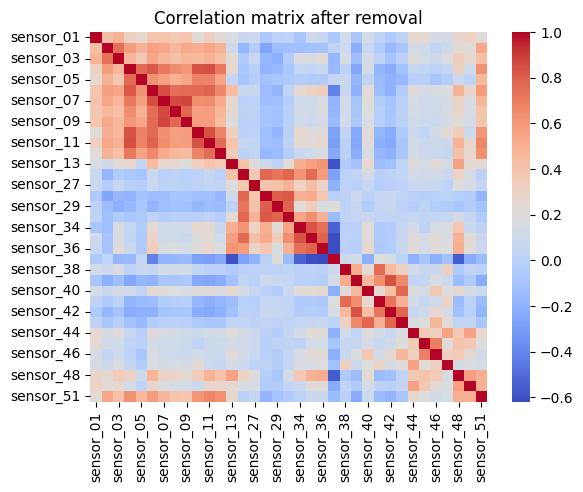

In [15]:
corr_matrix = df_data_train.drop(columns=non_feature_columns).dropna().corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title("Correlation matrix after removal")
plt.show()

# Frequency analysis 

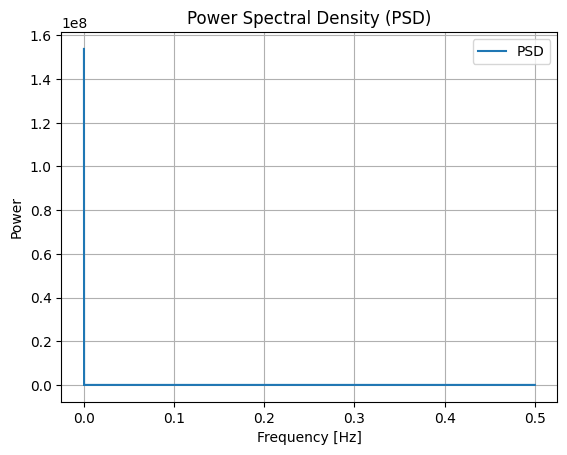

In [16]:
from core.plots_utils import plot_psd
plot_psd(df_data_train["sensor_12"].dropna().values, fs=1)

# Mark Danger Zone

In [17]:
from core.classification_utils import mark_danger_zone
ALPHA_PREDICTIVE_STRENGH = 1

mapping =  { "NORMAL": 0, "DANGER_ZONE": 1, "MAINTENANCE": 2, "BROKEN": 3}

df_data_train = mark_danger_zone(df_data_train,ALPHA_PREDICTIVE_STRENGH)
df_data_test = mark_danger_zone(df_data_test,ALPHA_PREDICTIVE_STRENGH)


Text(0.5, 1.0, 'Histogram State')

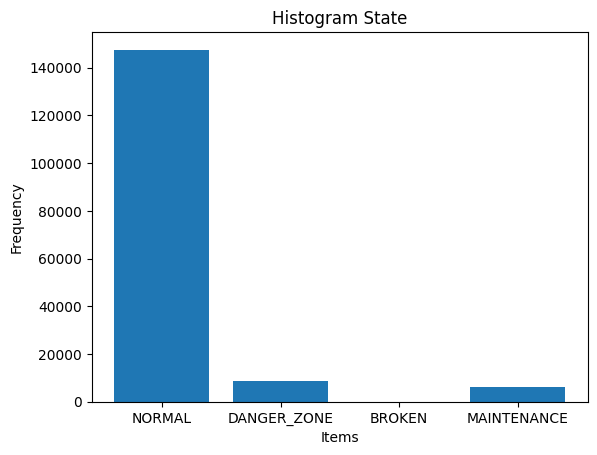

In [18]:
from collections import Counter 
states = Counter(df_data_train.predictive_machine_status.values)
labels = list(states.keys())
counts = list(states.values())
plt.bar(labels, counts)
plt.xlabel('Items')
plt.ylabel('Frequency')
plt.title('Histogram State')

In [19]:
df_data_train = df_data_train.copy()
df_data_train.loc[:, 'predictive_machine_status_label'] = df_data_train['predictive_machine_status'].map(mapping)
df_data_test = df_data_test.copy()
df_data_test.loc[:,'predictive_machine_status_label'] = df_data_test['predictive_machine_status'].map(mapping)

In [20]:
non_feature_columns += ["predictive_machine_status","predictive_machine_status_label"]

# Filling missing Data and Scaling

In [21]:
df_data_num = df_data_train.interpolate("linear") #.drop(columns=["timestamp","machine_status","predictive_machine_status","Split"]).apply(lambda col: col.fillna(col.median()))

/var/folders/g9/w9q193415dqd_3g5fx11gt_40000gn/T/ipykernel_28157/2535941734.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_data_num = df_data_train.interpolate("linear") #.drop(columns=["timestamp","machine_status","predictive_machine_status","Split"]).apply(lambda col: col.fillna(col.median()))


In [22]:
#df_data_num = df_data_num.merge(df_data_train[["timestamp","machine_status","predictive_machine_status","Split"]],left_index=True,right_index=True,how="left")

In [23]:
imputed_data = df_data_num.to_numpy()
imputed_df = df_data_num.reset_index(drop=True) #df_data.reset_index(drop=True)

In [24]:
from sklearn.preprocessing import RobustScaler #StandardScaler
sensor_cal= [x for x in imputed_df if "sensor" in x]
non_feature_columns = [x for x in imputed_df if "sensor" not in x ]
scaler = RobustScaler()
scaled_data = scaler.fit_transform( imputed_df[sensor_cal])
scaled_df = pd.DataFrame(scaled_data, columns=imputed_df[sensor_cal].columns)
scaled_df = scaled_df.merge(imputed_df[non_feature_columns],left_index=True,right_index=True)


# PCA analysis

In [25]:
from sklearn.decomposition import PCA

pca = PCA(n_components=15)

In [26]:
pca.fit(scaled_data)

PCA(n_components=15)

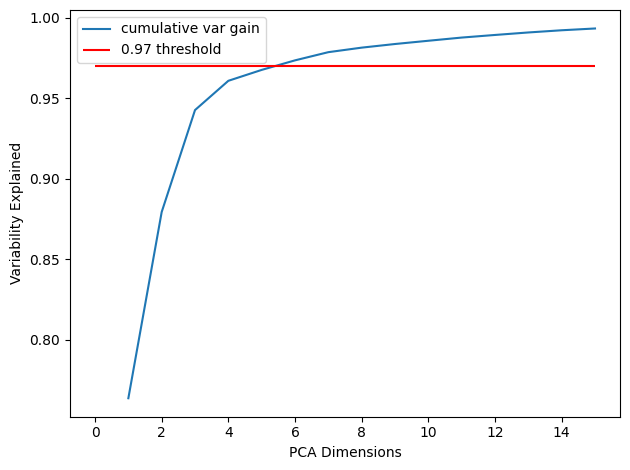

In [27]:
THRESHOLD_VARIABILITY = 0.97
plt.plot(np.arange(1,len(pca.explained_variance_ratio_)+1),np.cumsum(pca.explained_variance_ratio_),label="cumulative var gain")
plt.hlines(y=THRESHOLD_VARIABILITY,xmin=0,xmax=len(pca.explained_variance_ratio_),color="red",label=f"{THRESHOLD_VARIABILITY} threshold")
plt.legend()
plt.xlabel("PCA Dimensions")
plt.ylabel("Variability Explained")
plt.tight_layout()

In [28]:
pca = PCA(n_components=2)

In [29]:
projected_data = pca.fit_transform(scaled_data)

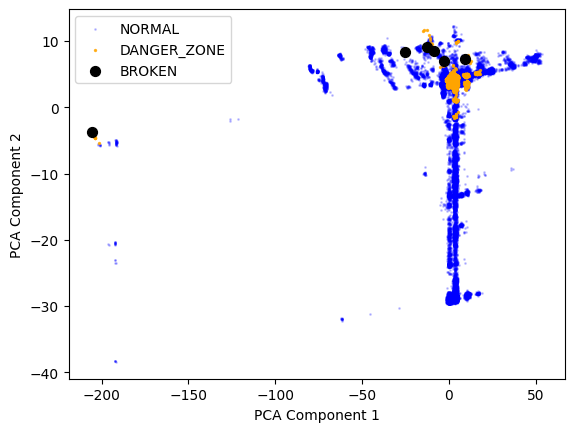

In [30]:
from core.plots_utils import plot_pca, plot_pca_by_cycle

plot_pca(scaled_df,projected_data)

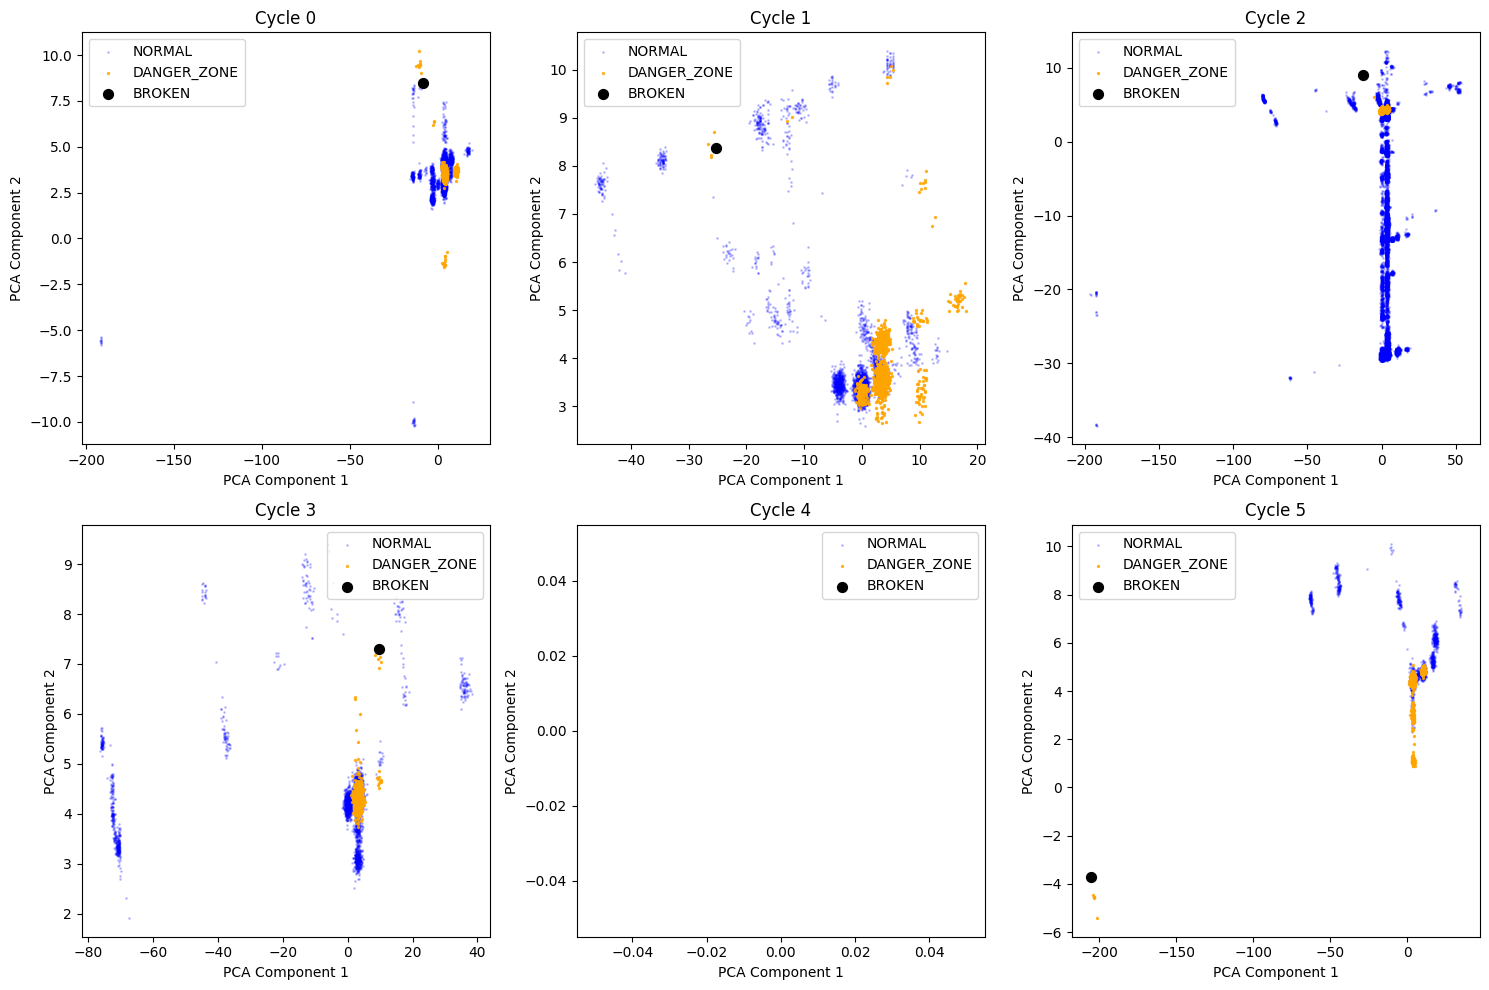

In [31]:
import numpy as np
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axs.flat):
    plot_pca_by_cycle(projected_data, imputed_df,ax,cycle=i)

for ax in axs.flat:
    ax.set_xlabel("PCA Component 1")  
    ax.set_ylabel("PCA Component 2")  
    ax.legend() 

plt.tight_layout()  
plt.show()

# Training Models

In [32]:
pca = PCA(n_components=5)
projected_data = pca.fit_transform(scaled_data)

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val= train_test_split(projected_data, scaled_df.predictive_machine_status_label.values, test_size=0.3, random_state=42, stratify=scaled_df.predictive_machine_status_label.values)

## Balance Classes 

In [34]:
normal_class = scaled_df[scaled_df["predictive_machine_status"] == 'NORMAL']
danger_class = scaled_df[scaled_df["predictive_machine_status"] == 'DANGER_ZONE']
broken_class = scaled_df[scaled_df["predictive_machine_status"] == 'BROKE']
maintenance_class = scaled_df[scaled_df["predictive_machine_status"] == 'MAINTENANCE']

In [35]:
from sklearn.utils import resample
majority_downsampled = resample(normal_class,
                                replace=False,    
                                n_samples=len(danger_class)*2, 
                                random_state=42)

In [36]:
balanced_data = pd.concat([majority_downsampled, danger_class,broken_class,maintenance_class])

In [37]:
X = projected_data[balanced_data.index.values]
Y = scaled_df.predictive_machine_status_label.values[balanced_data.index.values]

In [38]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.1, random_state=42,stratify=Y)

## Train Model

In [39]:
from hyperopt import hp,fmin,tpe
from core.classification_utils import optimize_xgb


In [40]:
inverse_custom_mapping = {val:key for key,val in mapping.items()}

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [01:43<00:00,  1.03s/trial, best loss: -0.892322136891378]
Best set of hyperparameters:  {'learning_rate': np.float64(0.08574613082214931), 'max_depth': np.int64(12), 'subsample': np.float64(0.624703707253398)}
Balanced accuracy is 0.8887
[0.89056167 0.77867903 0.99671593]
AUC is 0.9692


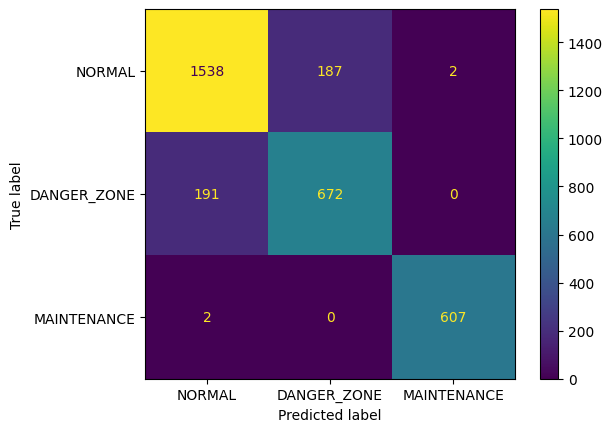

In [41]:
clf_model, best_params = optimize_xgb(X_train, y_train, X_val, y_val,inverse_custom_mapping)

In [42]:
print("Best set of hyperparameters: ", best_params)

Best set of hyperparameters:  {'learning_rate': np.float64(0.08574613082214931), 'max_depth': np.int64(12), 'subsample': np.float64(0.624703707253398)}


Balanced accuracy is 0.8887
[0.89056167 0.77867903 0.99671593]
AUC is 0.9692


np.float64(0.8886522073444528)

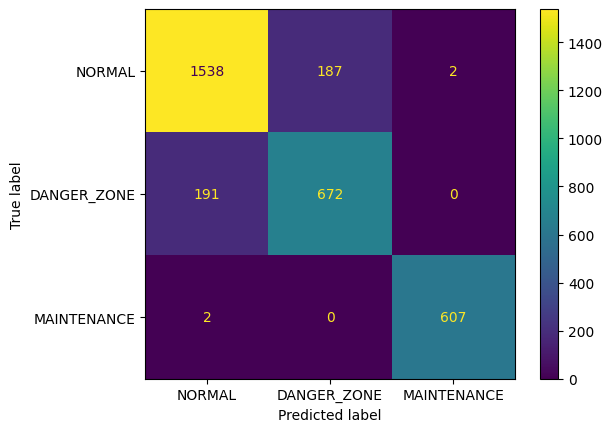

In [43]:
from core.classification_utils import evaluate_model
evaluate_model(X_val, y_val, clf_model,inverse_custom_mapping, verbose=True)

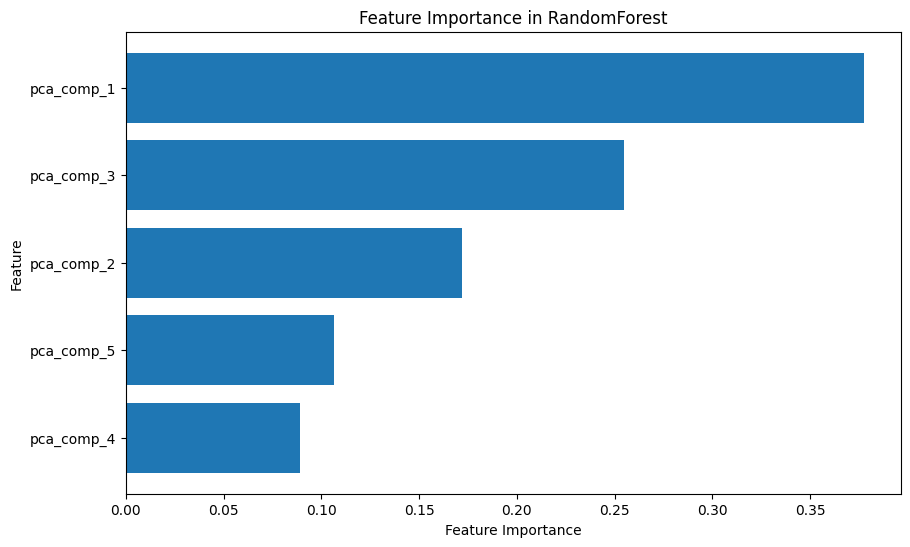

In [44]:
importances = clf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
features =[f"pca_comp_{i+1}" for i in range(scaled_data.shape[1])]
# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in RandomForest')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [45]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline(steps=[
    ('scaler', scaler),  
    ("pca",pca), 
    ("predictor",clf_model)
])

In [46]:
df_data_test_cleaned_all = df_data_test[df_data_train.keys()]

In [47]:
df_data_test_cleaned = df_data_test_cleaned_all[df_data_train.keys()].drop(columns=non_feature_columns).dropna()

In [48]:
X_full_T = df_data_test_cleaned.to_numpy()

In [49]:
Y_full_t = df_data_test_cleaned_all.loc[df_data_test_cleaned.index].predictive_machine_status_label.values

In [50]:
_ = evaluate_model(X_full_T, Y_full_t, pipeline,inverse_custom_mapping, verbose=True,plot=False)

Balanced accuracy is 0.7361
[0.52736653 0.         0.94484101]
AUC could not be calculated.


/Users/scafartogregory/Desktop/PDM/env_pdfm/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/Users/scafartogregory/Desktop/PDM/env_pdfm/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/Users/scafartogregory/Desktop/PDM/env_pdfm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:2480: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/scafartogregory/Desktop/PDM/env_pdfm/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Feature engineering 

In [51]:
from core.cleaning_utils import process_data
df_data_train, df_data_test, non_feature_columns = process_data(pd.read_csv("Data/DATA.csv"))

In [52]:
df_data_train = df_data_train.interpolate("linear")

/var/folders/g9/w9q193415dqd_3g5fx11gt_40000gn/T/ipykernel_28157/1689480274.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_data_train = df_data_train.interpolate("linear")


In [53]:
for column in df_data_train.drop(columns=non_feature_columns).keys() :
    df_data[f'rolling_mean_{column}'] = df_data[column].rolling(window=2*60, min_periods=1).mean().shift(1)
    df_data[f'rolling_std_{column}'] = df_data[column].rolling(window=2*60, min_periods=1).std().shift(1)

In [54]:

pipeline_preparation = Pipeline(steps=[
    ('scaler', scaler),  
    ("pca",pca), 
])

In [55]:
scaled_data = pipeline_preparation.fit_transform(df_data_train.drop(columns=non_feature_columns).apply(lambda col: col.fillna(col.median())))

In [56]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val= train_test_split(scaled_data, df_data_train.predictive_machine_status_label.values, test_size=0.1, random_state=42, stratify=df_data_train.predictive_machine_status_label.values)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 100/100 [00:47<00:00,  2.11trial/s, best loss: -0.681718071425847]
Best set of hyperparameters:  {'learning_rate': np.float64(0.972790798471283), 'max_depth': np.int64(13), 'subsample': np.float64(0.5429532952991155)}
Balanced accuracy is 0.6688
[0.98450297 0.35300926]
AUC could not be calculated.


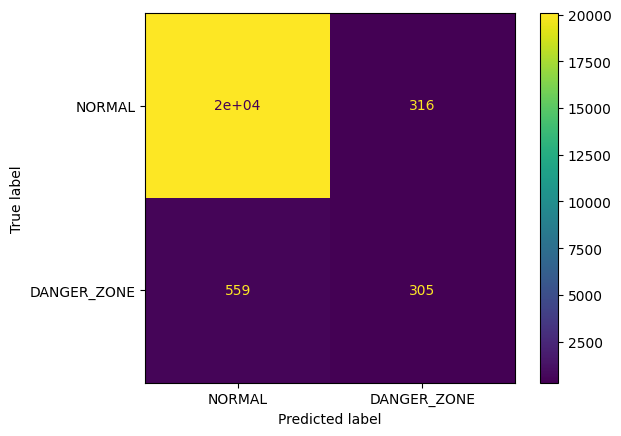

In [57]:
clf_model_With_feat, best_params_with_feat = optimize_xgb(X_train, y_train, X_val, y_val,inverse_custom_mapping)

In [58]:
from sklearn.pipeline import Pipeline

pipeline_eval = Pipeline(steps=[
    ('scaler', scaler),  
    ("pca",pca), 
    ("predictor",clf_model_With_feat)
])

In [59]:
df_data_test = df_data_test.interpolate("linear")
df_data_test_cleaned_all = df_data_test[df_data_train.keys()]
df_data_test_cleaned = df_data_test_cleaned_all[df_data_train.keys()].drop(columns=non_feature_columns)
X_full_T = df_data_test_cleaned.to_numpy()
Y_full_t = df_data_test_cleaned_all.loc[df_data_test_cleaned.index].predictive_machine_status_label.values

/var/folders/g9/w9q193415dqd_3g5fx11gt_40000gn/T/ipykernel_28157/127255400.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_data_test = df_data_test.interpolate("linear")


Balanced accuracy is 0.4769
[0.91351779 0.04027778]
AUC could not be calculated.


/Users/scafartogregory/Desktop/PDM/env_pdfm/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(
/Users/scafartogregory/Desktop/PDM/env_pdfm/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RobustScaler was fitted with feature names
  warnings.warn(


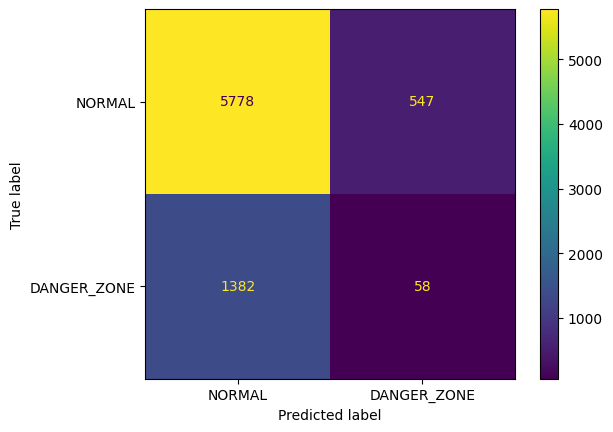

In [60]:
_ = evaluate_model(X_full_T, Y_full_t, pipeline_eval,inverse_custom_mapping, verbose=True)